In [22]:
import pandas as pd
from datetime import datetime

## Loading data

In [4]:
results = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients_procedure_na_removed.csv", encoding="Windows-1252")

C:\Users\frank\AppData\Local\Temp\ipykernel_4808\3517690854.py:1: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  results = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients_procedure_na_removed.csv", encoding="Windows-1252")


- Add Age

In [5]:
results['age'] = pd.to_datetime(results['procedure_date']).dt.year - pd.to_datetime(results['birth_date']).dt.year 
results = results[results['age'] >= 0] # remove rows with negative age
results.columns.tolist()

['id_x_x',
 'sikka_sub_task_x_x',
 'sikka_sub_task_operation_x_x',
 'last_updated_x_x',
 'name_x',
 'office_x_x',
 'patient',
 'guarantor_x',
 'provider_x',
 'description',
 'state_x',
 'status',
 'visible_to_patient',
 'amount',
 'estimated_cost',
 'insurance_coverage',
 'tooth_from',
 'tooth_to',
 'surface',
 'clinical_condition_id',
 'collection_provider_id',
 'created_by',
 'last_updated_by',
 'primary_insurance_estimate',
 'secondary_insurance_estimate',
 'surface_quadrant_type',
 'appointment_sr_no',
 'plan_sr_no',
 'entry_date',
 'insurance_payment',
 'treatment_plan_status',
 'procedure_date',
 'priority',
 'doctor_note',
 'doctor_note_date',
 'approved',
 'video_link',
 'from_pms_x_x',
 'date_executed',
 'entry_date_converted',
 'id_y_x',
 'from_pms_y_x',
 'sikka_sub_task_y_x',
 'sikka_sub_task_operation_y_x',
 'last_updated_y_x',
 'user',
 'uuid',
 'patient_id',
 'guarantor_y',
 'office_y_x',
 'fullname',
 'first_name',
 'middle_name',
 'last_name',
 'birth_date',
 'address',

- Filter only 7 year time window with 4543 unique patients

In [14]:
# Ensure both 'first_visit' and 'procedure_date' are in datetime format
results['first_visit'] = pd.to_datetime(results['first_visit'], errors='coerce')
results['procedure_date'] = pd.to_datetime(results['procedure_date'], errors='coerce')

# Localize timezone
results['first_visit'] = results['first_visit'].dt.tz_localize(None)
results['procedure_date'] = results['procedure_date'].dt.tz_localize(None)

# Compute the difference in days
results['visit_procedure_diff'] = (results['procedure_date'] - results['first_visit']).dt.days

# Filter for differences of at least 7 years (7*365 days)
results = results[results['visit_procedure_diff'] >= 7 * 365]

# Reset index
results.reset_index(drop=True, inplace=True)


In [15]:
# Get unique patients
unique_patients = results['patient'].unique()
len(unique_patients)

4543

- Get unique procedure codes and define the risk factors

In [19]:
treatment_df = results[['patient_id', 'patient', 'procedure_date', 'procedure_code_y']]
patient_df = results[['patient_id', 'patient', 'birth_date', 'first_visit']].drop_duplicates()

procedure_codes = treatment_df['procedure_code_y'].unique()
treatment_df['procedure_date'] = pd.to_datetime(treatment_df['procedure_date'])
# Define the risk factors based on the procedure code
risk_factors = {}

for code in procedure_codes:
    # Check the length of the code and apply the rules
    if len(str(code)) == 4:
        if str(code)[0] == '1' or str(code)[0] == '2':
            risk_factors[code] = 0.5
        elif str(code)[0] == '3' or str(code)[0] == '4' or str(code)[0] == '5':
            risk_factors[code] = 0
        else:
            risk_factors[code] = 0
    elif len(str(code)) == 5:
        if str(code)[0] == '1':
            risk_factors[code] = 1
        elif str(code)[0] == '2':
            risk_factors[code] = -1
        elif str(code)[0] == '3':
            risk_factors[code] = -1.5
        elif str(code)[0] == '4':
            risk_factors[code] = -2
        elif str(code)[0] == '5':
            risk_factors[code] = -2.5
        elif str(code)[0] == '6':
            risk_factors[code] = -3
        elif str(code)[0] == '7':
            risk_factors[code] = -3.5
        elif str(code)[0] == '8':
            risk_factors[code] = -4
        elif str(code)[0] == '9':
            risk_factors[code] = 0
        else:
            risk_factors[code] = 0

# Map the risk factors to the procedure codes in the treatment dataframe
treatment_df['risk_level'] = treatment_df['procedure_code_y'].map(risk_factors)


C:\Users\frank\AppData\Local\Temp\ipykernel_4808\2007052172.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df['risk_level'] = treatment_df['procedure_code_y'].map(risk_factors)


If the procedure code is 4 digits long:  
Codes starting with 1 or 2 are assigned a risk level of 0.5.  
Codes starting with 3, 4, or 5 are assigned a risk level of 0.  


If the procedure code is 5 digits long, risk levels are assigned based on the first digit:  
Codes starting with 1 get a risk level of 1.  
Codes starting with 2 to 8 have negative risk levels, decreasing incrementally.  
Codes starting with 9 or any other number get a risk level of 0.  


## Based on Prithvi's work; Crowns data loading

In [50]:
ALL_FEATURES = {
    # Preventive
    "polishing": [11101, 11107],
    "fluoride_custom_appliances": [12601, 12602],
    "medication_custom_appliances": [12701, 12702],
    "pit_and_fissure_sealants": [13401, 13409],
    "preventive_restorative_resin": [13411, 13419],
    "bruxism_periodontal_appliances": [14611, 14612],
    "tmj_appliances": [14711, 14712, 14721, 14722],
    "recontouring_of_natural_teeth_for_functional_reasons": [16401, 16409],
    "occlusion_adjustment": [16511, 16512, 16513, 16514, 16519],
    # Restorative
    "caries_trauma_pain_control": [20111, 20119, 20121, 20129, 20131, 20139],
    "restorations_amalgam": [21114, 21115, 21214, 21215, 21224, 21225, 23324, 23325, 21301, 21302],
    "pins_retentive": [21401, 21402, 21403, 21404, 21405],
    "posts_prefabricated_retentive": [25731, 25732, 25733],
    "restorations_prefabricated_plastic_permanent_teeth": [22501, 22511],
    "restorations_tooth_coloured": [23104, 23105, 23314, 23315, 23514, 23515, 23601, 23602],
    "restorations_onlays_cast_metal_indirect": [25511],
    "restorations_onlays_composite_compomer_processed_bonded": [25521],
    "restorations_onlays_porcelain_ceramic_polymer_glass_bonded": [25531],
    "posts_cast_metal_separate_procedure": [25711, 25712, 25713],
    "posts_cast_metal_concurrent_with_impression": [25721, 25722, 25723],
    "posts_prefabricated_retentive_cast_core": [25741, 25742, 25743],
    "posts_prefabricated_non_bonded_core": [25751, 25752, 25753, 25754, 25755, 25756],
    "posts_prefabricated_bonded_core": [25761, 25762, 25763, 25764, 25765, 25766],
    "post_removal": [25781, 25782, 25783, 25784, 25789],
    "crowns_acrylic_composite_compomer_indirect": [27111, 27113, 27115],
    "crowns_acrylic_composite_compomer_direct": [27121, 27125],
    "crowns_acrylic_composite_compomer_cast_metal_base": [27131, 27135],
    "crowns_porcelain_ceramic_polymer_glass": [27201, 27205],
    "crowns_porcelain_ceramic_polymer_glass_fused_to_metal": [27211, 27215],
    "crowns_cast_metal": [27301, 27305],
    "crowns_existing_partial_denture_clasp": [27401, 27409],
    "tooth_preparation_for_overdentures": [28101],
    "recementation_rebonding": [29101, 29102, 29103, 29104],
    "reinsertion_recementation_implant_supported_crown": [29111, 29112, 29113, 29114],
    "removal_inlays_onlays_crowns_veneers": [29301, 29302, 29303, 29304],
    "removal_implant_supported_crowns": [29311, 29312, 29313, 29314],
    # Endodontic
    "pulpotomy_permanent_teeth": [32221, 32222],
    "pulpotomy_primary_teeth": [32231, 32232],
    "pulpotomy_permanent_teeth_concurrent": [32241, 32242],
    "pulpectomy_permanent_teeth": [32311, 32312, 32313, 32314],
    "pulpectomy_primary_teeth": [32321, 32322],
    "apexification_apexogenesis": [33601, 33602, 33603, 33604],
    "reinsertion_dentogenic_media": [33611, 33612, 33613, 33614],
    "obturation_apexified_canal": [33621, 33622, 33623, 33624],
    "apicoectomy_maxillary_anterior": [34111, 34112],
    "apicoectomy_maxillary_bicuspid": [34121, 34122, 34123],
    "apicoectomy_maxillary_molar": [34131, 34132, 34133, 34134],
    "apicoectomy_mandibular_anterior": [34141, 34142],
    "apicoectomy_mandibular_bicuspid": [34151, 34152, 34153],
    "apicoectomy_mandibular_molar": [34161, 34162, 34163, 34164],
    "retrofill_maxillary_anterior": [34211, 34212],
    "retrofill_maxillary_bicuspid": [34221, 34222, 34223, 34224],
    "retrofill_maxillary_molar": [34231, 34232, 34233, 34234],
    "retrofill_mandibular_anterior": [34241, 34242],
    "retrofill_mandibular_bicuspid": [34251, 34252, 34253, 34254],
    "retrofill_mandibular_molar": [34261, 34262, 34263, 34264],
    "perforations_nonsurgical": [34511],
    "perforations_surgical": [34521, 34522, 34523],
    "open_and_drain": [39201, 39202]
}

CROWNS = [27111, 27113, 27115,
               27121, 27125,
               27131, 27135,
               27201, 27205,
               27211, 27215,
               27301, 27305,
               27401, 27409,
               29111, 29112, 29113, 29114,
               29301, 29302, 29303, 29304,
               29311, 29312, 29313, 29314]

In [51]:
from datetime import datetime
# Convert 'procedure_date' to datetime format
treatment_df['procedure_date'] = pd.to_datetime(treatment_df['procedure_date'])

# Function to calculate years since a treatment based on snapshot year
def calculate_years_since_treatment(procedure_date, snapshot_year):
    # Use the snapshot year to calculate the time difference
    snapshot_date = datetime(snapshot_year, 12, 31)
    return (snapshot_date - procedure_date).days // 365

# Function to calculate recency weight based on the time passed since the procedure
def calculate_recency_weight(procedure_date, snapshot_year):
    years_since_treatment = calculate_years_since_treatment(procedure_date, snapshot_year)
    if years_since_treatment <= 0.5:  # within 6 months
        return 1.0
    elif years_since_treatment <= 1.0:  # 6 months to 1 year
        return 0.7
    elif years_since_treatment <= 2.0:  # 1 to 2 years
        return 0.5
    else:  # more than 2 years ago
        return 0.3

# Function to calculate the treatment score based on risk level and recency
def calculate_treatment_score(risk_score, procedure_date, snapshot_year):
    
    # Calculate recency weight
    recency_weight = calculate_recency_weight(procedure_date, snapshot_year)
    
    # Final treatment score = risk score * recency weight
    return risk_score * recency_weight

# Function to get the treatment data for the past 3 years for a patient
def get_patient_treatments_rolling_window(patient_id, snapshot_year):
    # Filter treatments for the given patient
    patient_treatments = treatment_df[treatment_df['patient_id'] == patient_id]
    
    # Get treatments within the past 3 years from the snapshot year
    start_year = snapshot_year - 3
    end_year = snapshot_year
    patient_treatments = patient_treatments[
        (patient_treatments['procedure_date'].dt.year >= start_year) &
        (patient_treatments['procedure_date'].dt.year < end_year)
    ]
    
    return patient_treatments

# Function to calculate visit frequency based on treatments in the past 3 years
def calculate_visit_frequency(patient_id, snapshot_year):
    # Get all treatments for the patient
    patient_treatments = treatment_df[treatment_df['patient_id'] == patient_id]
    
    # Get treatments within the past 3 years from the snapshot year
    start_year = snapshot_year - 3
    end_year = snapshot_year
    patient_treatments = patient_treatments[
        (patient_treatments['procedure_date'].dt.year >= start_year) &
        (patient_treatments['procedure_date'].dt.year < end_year)
    ]
    
    # Count the number of visits in the past 3 years
    num_visits = len(patient_treatments)
    
    # Calculate the frequency weight
    if num_visits >= 6:  # Frequent visits: 2 or more visits per year
        return 1.0
    elif num_visits >= 3:  # Moderate visits: 1 visit per year
        return 0.7
    else:  # Infrequent visits: less than 1 visit per year
        return 0.5

C:\Users\frank\AppData\Local\Temp\ipykernel_4808\1679925412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df['procedure_date'] = pd.to_datetime(treatment_df['procedure_date'])


In [52]:
# 15 mins
# Function to calculate health score for a patient based on their treatments in the past 3 years
def calculate_health_score(patient_id, snapshot_year):
    # Get treatments for the patient within the past 3 years (including the snapshot year)
    patient_treatments = get_patient_treatments_rolling_window(patient_id, snapshot_year)
    
    # If the patient has no treatments in the last 3 years, return a default score
    if patient_treatments.empty:
        return 0, None  # You can choose a different default value or behavior here
    
    # Calculate treatment score for each treatment
    patient_treatments['treatment_score'] = patient_treatments.apply(
        lambda row: calculate_treatment_score(row['risk_level'], row['procedure_date'], snapshot_year),
        axis=1
    )
    
    # Sum up the scores for the last 3 years
    total_score = patient_treatments['treatment_score'].sum()
    
    # Add the frequency factor to the score based on treatments in the last 3 years
    visit_frequency_weight = calculate_visit_frequency(patient_id, snapshot_year)
    total_score *= visit_frequency_weight
    
    # Apply crowns event logic for the next 2 years
    crowns_event = check_crowns_event(patient_id, snapshot_year)
    if crowns_event:
        # Calculate time to crowns
        time_to_crowns = calculate_time_to_crowns(patient_id, snapshot_year)
        return total_score, time_to_crowns
    
    return total_score, None

def look_back_and_generate_features(patient_id, snapshot_year):
    # Get treatments for the patient within the past 3 years (including the snapshot year)
    patient_treatments = get_patient_treatments_rolling_window(patient_id, snapshot_year)
    
    # If the patient has no treatments in the last 3 years, return a default score
    if patient_treatments.empty:
        return None
    
    # Initialize the dictionary to store the features
    features = {}
    
    # Loop through each feature category and its respective codes in ALL_FEATURES
    for feature_name, feature_codes in ALL_FEATURES.items():
        # Initialize the count for this feature
        features[feature_name] = 0
        
        # Loop through each treatment in the patient's data
        for _, treatment in patient_treatments.iterrows():
            # If the treatment code is in the list of feature codes, increment the count
            if treatment['procedure_code_y'] in feature_codes:
                features[feature_name] += 1

    # Additionally check for crowns
    features['crowns'] = 0
    for _, treatment in patient_treatments.iterrows():
        if treatment['procedure_code_y'] in CROWNS:
            features['crowns'] += 1

    features['starts_with_4_procedures'] = len(patient_treatments[
        (patient_treatments['procedure_code_y'].astype(str).str.startswith('4')) & 
        (patient_treatments['procedure_code_y'].astype(str).str.len() == 5)
    ])
    features['starts_with_5_procedures'] = len(patient_treatments[
        (patient_treatments['procedure_code_y'].astype(str).str.startswith('5')) & 
        (patient_treatments['procedure_code_y'].astype(str).str.len() == 5)
    ])
    features['starts_with_6_procedures'] = len(patient_treatments[
        (patient_treatments['procedure_code_y'].astype(str).str.startswith('6')) & 
        (patient_treatments['procedure_code_y'].astype(str).str.len() == 5)
    ])
    features['starts_with_7_procedures'] = len(patient_treatments[
        (patient_treatments['procedure_code_y'].astype(str).str.startswith('7')) & 
        (patient_treatments['procedure_code_y'].astype(str).str.len() == 5)
    ])
    return features

# Function to check if there is a crowns event in the next 2 years
def check_crowns_event(patient_id, snapshot_year):
    # Get all treatments for the patient
    patient_treatments = treatment_df[treatment_df['patient_id'] == patient_id]
    
    # Filter for crowns procedures within the next 2 years
    start_year = snapshot_year
    end_year = snapshot_year + 2
    
    # Define crowns procedure codes (codes that start with '27' or '29')
    crowns_codes = {code for code in range(27000, 29000) if str(code).startswith(('27', '29'))}
    
    # Filter treatments for the patient that are within the year range and are crowns procedures
    crowns_treatments = patient_treatments[
        (patient_treatments['procedure_code_y'].isin(crowns_codes)) &
        (patient_treatments['procedure_date'].dt.year > start_year) &
        (patient_treatments['procedure_date'].dt.year <= end_year)
    ]
    
    # Return True if any crowns treatments are found within the next 2 years, else False
    return not crowns_treatments.empty



# Function to calculate the time to the next crowns event
def calculate_time_to_crowns(patient_id, snapshot_year):
    # Get all treatments for the patient
    patient_treatments = treatment_df[treatment_df['patient_id'] == patient_id]
    
    # Filter for crowns procedures within the next 2 years
    start_year = snapshot_year
    end_year = snapshot_year + 2
    
    # Define crowns procedure codes (codes that start with '32' or '33')
    crowns_codes = {code for code in range(27000, 29000) if str(code).startswith(('27', '29'))}
    
    # Filter treatments for the patient that are within the year range and are crowns procedures
    crowns_treatments = patient_treatments[
        (patient_treatments['procedure_code_y'].isin(crowns_codes)) &
        (patient_treatments['procedure_date'].dt.year > start_year) &
        (patient_treatments['procedure_date'].dt.year <= end_year)
    ]

    if not crowns_treatments.empty:
        # Get the first crowns event in the next 2 years
        next_crowns = crowns_treatments.iloc[0]
        time_to_event = (next_crowns['procedure_date'] - datetime(snapshot_year, 12, 31)).days
        return time_to_event
    
    return None

def update_rolling_health_scores_with_features():
    patient_scores = []
    
    # Iterate over each patient
    for patient_id in patient_df['patient_id']:
        # Get the first treatment date for the patient
        first_visit_date = treatment_df[treatment_df['patient_id'] == patient_id]['procedure_date'].min()
        first_visit_year = first_visit_date.year
        
        # Calculate health scores starting from the first visit year
        for year in range(first_visit_year + 1, 2025):  # Go up to 2025 or the current year
            health_score, time_to_crowns = calculate_health_score(patient_id, year)
            
            # Extract the necessary features
            patient_treatments = get_patient_treatments_rolling_window(patient_id, year)
            
            # Calculate recency for the treatments
            recency_scores = patient_treatments['procedure_date'].apply(
                lambda date: calculate_recency_weight(date, year)
            ).mean()
            
            # Calculate visit frequency
            visit_frequency = calculate_visit_frequency(patient_id, year)
            
            # Calculate total risk (mean risk score from all treatments)
            avg_risk_level = patient_treatments['risk_level'].mean() if not patient_treatments.empty else 0
            
            # Generate additional features from the look-back function
            look_back_features = look_back_and_generate_features(patient_id, year)
            
            # If look-back features are available, merge them into the output dictionary
            if look_back_features:
                # Add features to the record, including the look-back features
                patient_scores.append({
                    'patient_id': patient_id,
                    'year': year,
                    'health_score': health_score,
                    'time_to_crowns': time_to_crowns,
                    'recency_score': recency_scores,
                    'visit_frequency': visit_frequency,
                    'average_risk_level': avg_risk_level,
                    'num_visits': len(patient_treatments),
                    **look_back_features  # Merge the features from look-back
                })
    
    # Convert the results to a DataFrame
    health_scores_df = pd.DataFrame(patient_scores)
    return health_scores_df

# Get and print health scores with additional features (including look-back features)
health_scores_with_features_df = update_rolling_health_scores_with_features()
print(health_scores_with_features_df)

       patient_id  year  health_score  time_to_crowns  recency_score  \
0            2479  1999         0.980             NaN       0.700000   
1            2479  2000         0.300             NaN       0.633333   
2            2479  2001         0.800             NaN       0.481818   
3            2479  2002        -0.850             NaN       0.500000   
4            2479  2003        -1.150             NaN       0.546154   
...           ...   ...           ...             ...            ...   
53142        6988  2010         0.700             NaN       0.333333   
53143        6988  2011        -0.150             NaN       0.300000   
53144        6696  2008         0.175             NaN       0.700000   
53145        6696  2009         0.125             NaN       0.500000   
53146        6696  2010         0.075             NaN       0.300000   

       visit_frequency  average_risk_level  num_visits  polishing  \
0                  0.7            0.666667           3          0 

## Patient risk score

In [55]:
health_scores_with_features_df["time_to_crowns"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
53142   NaN
53143   NaN
53144   NaN
53145   NaN
53146   NaN
Name: time_to_crowns, Length: 53147, dtype: float64

In [61]:
# drop rows where the time to crowns is negative but keep the null values
health_scores_with_features_df_c = health_scores_with_features_df[(health_scores_with_features_df['time_to_crowns'] >= 0) | (health_scores_with_features_df['time_to_crowns'].isnull())]
health_scores_with_features_df_c.reset_index(drop=True, inplace=True)
health_scores_with_features_df_c["time_to_crowns"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
53142   NaN
53143   NaN
53144   NaN
53145   NaN
53146   NaN
Name: time_to_crowns, Length: 53147, dtype: float64

In [63]:
# Unique patient ids
unique_patient_ids = health_scores_with_features_df_c['patient_id'].unique()
unique_patient_ids

array([2479, 6970, 6239, ..., 3536, 6988, 6696], dtype=int64)

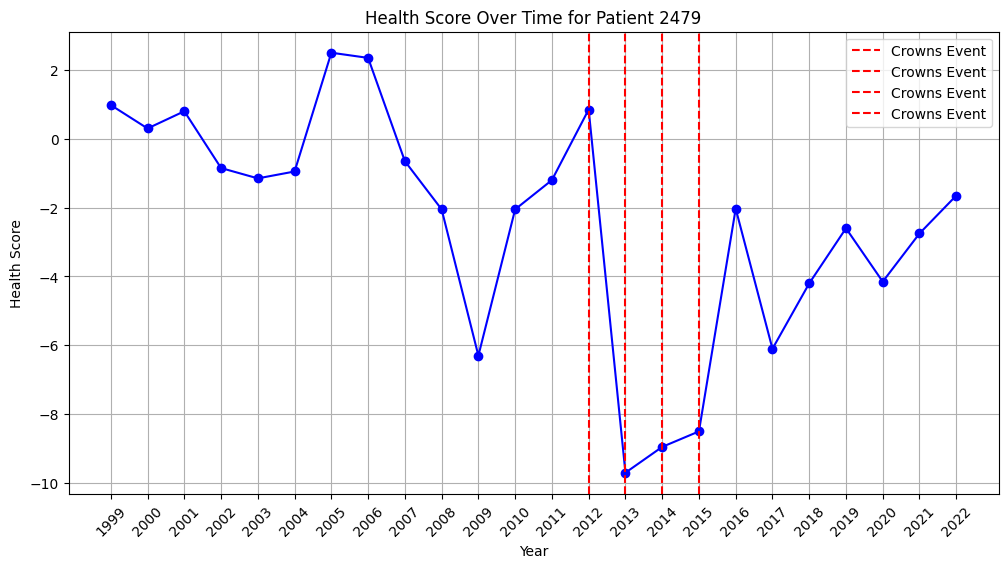

In [64]:
import matplotlib.pyplot as plt

# Select a patient to plot
patient_id = 2479

# Filter the health scores for the selected patient
patient_health_scores = health_scores_with_features_df_c[health_scores_with_features_df_c['patient_id'] == patient_id]

# Plot the health scores over the years
plt.figure(figsize=(12, 6))
plt.plot(patient_health_scores['year'], patient_health_scores['health_score'], marker='o', color='b')
plt.title(f'Health Score Over Time for Patient {patient_id}')
plt.xlabel('Year')
plt.ylabel('Health Score')

# Add vertical lines for crown events
crowns_events = patient_health_scores[patient_health_scores['time_to_crowns'].notnull()]
for _, event in crowns_events.iterrows():
    plt.axvline(event['year'], color='r', linestyle='--', label='Crowns Event')

# Set the x-axis as integer values for the years
plt.xticks(patient_health_scores['year'].unique(), rotation=45)

# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()


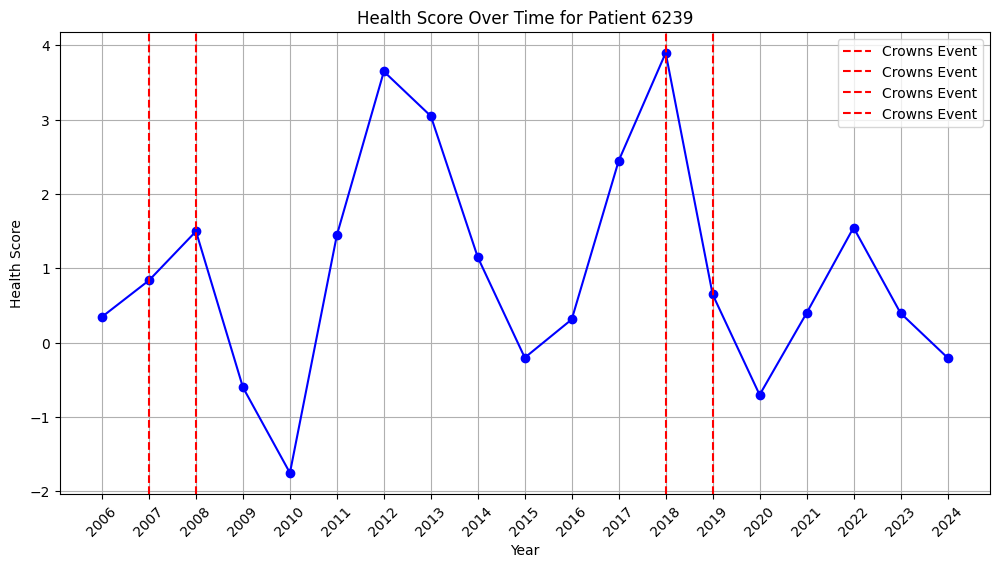

In [ ]:
import matplotlib.pyplot as plt
patient_id = 6239

# Filter the health scores for the selected patient
patient_health_scores = health_scores_with_features_df_c[health_scores_with_features_df_c['patient_id'] == patient_id]

# Plot the health scores over the years
plt.figure(figsize=(12, 6))
plt.plot(patient_health_scores['year'], patient_health_scores['health_score'], marker='o', color='b')
plt.title(f'Health Score Over Time for Patient {patient_id}')
plt.xlabel('Year')
plt.ylabel('Health Score')

# Add vertical lines for crown events
crowns_events = patient_health_scores[patient_health_scores['time_to_crowns'].notnull()]
for _, event in crowns_events.iterrows():
    plt.axvline(event['year'], color='r', linestyle='--', label='Crowns Event')

# Set the x-axis as integer values for the years
plt.xticks(patient_health_scores['year'].unique(), rotation=45)

# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()


## Feature importance for prediction

In [76]:
health_scores_with_features_df_c = health_scores_with_features_df_c.dropna(axis=1, how='all')
health_scores_with_features_df_c = health_scores_with_features_df_c.loc[:, (health_scores_with_features_df_c != 0).any(axis=0)]
patient_id = 2479
health_scores_with_features_df_c[health_scores_with_features_df_c['patient_id'] == patient_id]

,patient_id,year,health_score,time_to_crowns,recency_score,visit_frequency,average_risk_level,num_visits,polishing,pit_and_fissure_sealants,...,removal_inlays_onlays_crowns_veneers,removal_implant_supported_crowns,pulpotomy_permanent_teeth,pulpectomy_permanent_teeth,open_and_drain,crowns,starts_with_4_procedures,starts_with_5_procedures,starts_with_6_procedures,starts_with_7_procedures
0,2479,1999,0.98,NaN,0.700000,0.7,0.666667,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2479,2000,0.30,NaN,0.633333,1.0,0.111111,9,0,0,...,1,0,0,0,0,1,0,0,0,0
2,2479,2001,0.80,NaN,0.481818,1.0,0.181818,11,0,0,...,1,0,0,0,0,1,0,0,0,0
3,2479,2002,-0.85,NaN,0.500000,1.0,-0.107143,14,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2479,2003,-1.15,NaN,0.546154,1.0,-0.115385,13,1,0,...,0,0,0,0,0,0,1,0,0,0
5,2479,2004,-0.95,NaN,0.390909,1.0,-0.227273,11,1,0,...,0,0,0,0,0,0,1,0,0,0
6,2479,2005,2.50,NaN,0.557143,1.0,0.230769,14,2,0,...,0,0,0,0,0,0,1,0,0,0
7,2479,2006,2.35,NaN,0.520000,1.0,0.500000,10,1,0,...,0,0,0,0,0,0,0,0,0,0
8,2479,2007,-0.65,NaN,0.446667,1.0,0.107143,15,2,0,...,0,0,0,0,0,0,0,0,1,0
9,2479,2008,-2.05,NaN,0.572727,1.0,-0.318182,11,2,0,...,0,0,0,0,0,0,1,0,1,0


In [78]:
# Drop null values
health_scores_with_features_df_c1 = health_scores_with_features_df_c.dropna()

# Drop 'patient_id' and 'year' columns from the DataFrame before calculating correlations
health_scores_without_id_year = health_scores_with_features_df_c1.drop(columns=['patient_id', 'year'])

# Calculate correlation with 'health_score'
correlations = health_scores_without_id_year.corr()['time_to_crowns'].sort_values(ascending=False)

print(correlations)

time_to_crowns                                                1.000000
restorations_onlays_porcelain_ceramic_polymer_glass_bonded    0.027356
average_risk_level                                            0.023705
pins_retentive                                                0.023195
recontouring_of_natural_teeth_for_functional_reasons          0.022627
removal_implant_supported_crowns                              0.020691
pulpectomy_permanent_teeth                                    0.018107
preventive_restorative_resin                                  0.017976
starts_with_4_procedures                                      0.016211
crowns_porcelain_ceramic_polymer_glass_fused_to_metal         0.016023
posts_prefabricated_bonded_core                               0.013360
crowns                                                        0.012879
caries_trauma_pain_control                                    0.011719
restorations_onlays_composite_compomer_processed_bonded       0.009699
pulpot

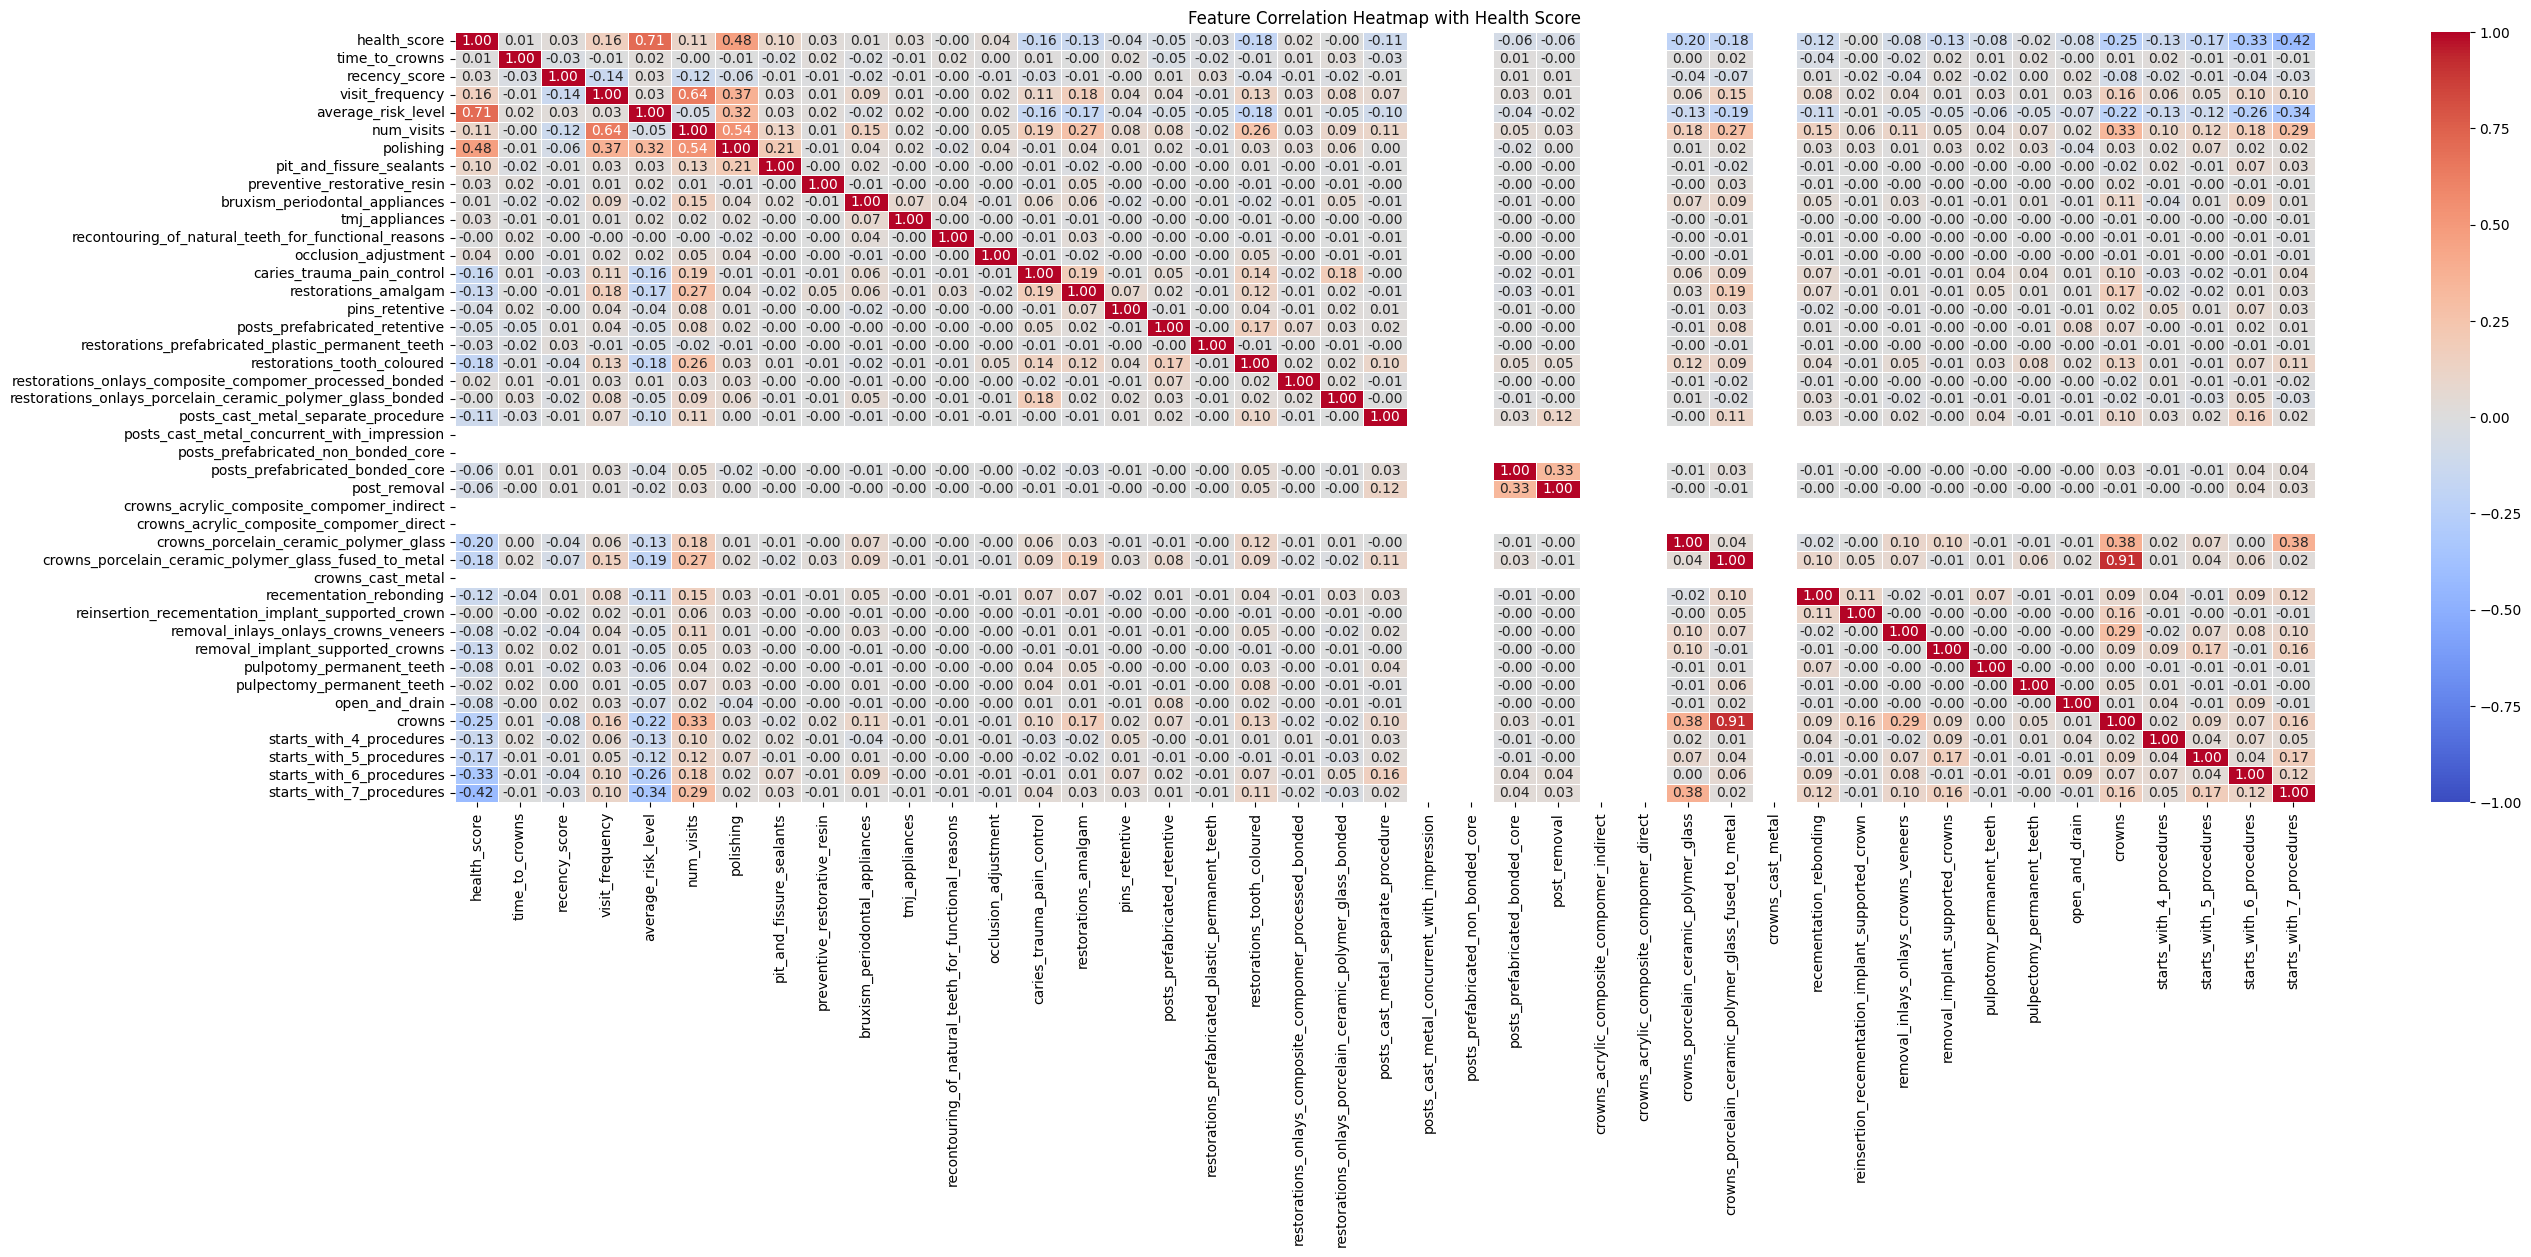

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop null values
health_scores_with_features_df_c1 = health_scores_with_features_df_c.dropna()

# Drop 'patient_id' and 'year' columns
health_scores_without_id_year = health_scores_with_features_df_c1.drop(columns=['patient_id', 'year'])

# Calculate the correlation matrix
correlation_matrix = health_scores_without_id_year.corr()

# Plot the heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap with Health Score')
plt.show()

## Try to automate the process
Collected All the Helper Functions
Identified Common Factors – The functions were all centered around:  

A treatment type ("root_canal")  
A set of procedure codes (ROOT_CANALS)  
A time-based rolling window for analysis  
Features that are extracted from the past treatments.

- Instead of writing separate versions of the same logic for different treatments, I built a single framework where:  
The treatment type and procedure codes are passed as parameters.  
A feature dictionary (ALL_FEATURES) allows easy expansion for tracking other conditions.

- Instead of manually computing health scores per patient, per year, I wrapped everything into a single function that:
Loops through patients and years; Computes all relevant scores dynamically; Outputs a structured DataFrame.